In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation
from scipy.sparse        import diags_array
from scipy.sparse.linalg import spsolve
%matplotlib inline
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))
display(HTML(""" <style>.output_png { display: table-cell; text-align: center; vertical-align: middle; }</style> """))
display(HTML("<style> div.text_cell_render { line-height: 2.0; } </style>"))    # Adjust linespread

In [ ]:
# --- Now we want to implement the screen ---

# To do this we need to model the screen to the right and left (assuming our screen starts to the right x0)
# On the right we replicate the toy model but with right boundary condition u_x(screen, t)=0.01 (or some small number)
# On the left of the screen we need to solve the diffusion equation again but wiht the initial condition of x_0=0
# and have boundary conditions of u_x(screen, t)=-0.01 such that is the negative of the right side of the screen,
# and have a zero BC at the end of the room L

# --- To investigate further ---

# The use of a function of x,t as the boudnary condition at the screen
# Implementation of advection to the model 

# ---- What we want to find ----

# Find an optimal aplha (diffusivity consant inside screen)

# TODO
# Write up backward euler using the CFD method
# Invetsigate the fuxuation of alpha/ screen width
# Begin looking at advection

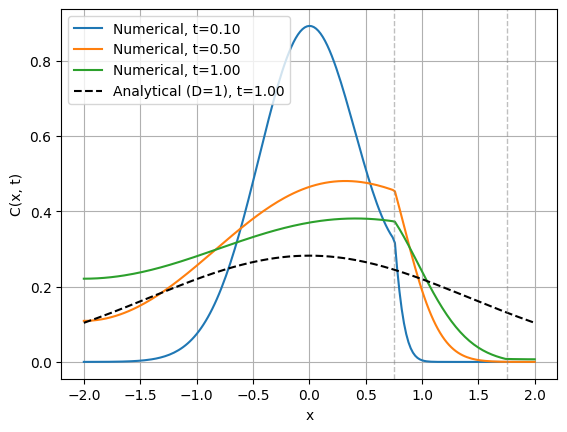

In [ ]:
# ** Toy Model inital contion and exact solution ** #
def make_D(x, alpha, w):
    D = np.ones_like(x)
    D[np.abs(x - 1.25) <= w/2] = alpha 
    return D


def f(x):
    x0 = x[len(x)//2]
    epsilon = 0.05 
    
    U0 = np.zeros_like(x)
    mask = np.abs(x - x0) <= epsilon
    U0[mask] = 1 / (2 * epsilon) 
    return U0

def U_exact(x, t, D):
    if t < 1e-10:
        return f(x)
    
    u_exact = 1.0 / (2 * np.sqrt(np.pi * D * t)) * np.exp(-x**2 / (4 * D * t))
    
    return u_exact

# ** Set parameters ** #
N = 80000    # Increased timesteps for stability and accuracy
T = 1.0      # final time 
t = np.linspace(0.0, T, N + 1)      # Time grid (start at 0.0)

M = 200    # Increased spatial points for accuracy
x = np.linspace(-2.0, 2.0, M + 1)    # Space grid

alpha = 0.1 # Diffusion coefficient in the 'defect' region
w = 1
D = make_D(x, alpha, w)
D_max = np.max(D) # Maximum diffusion for stability check

dx = x[1] - x[0] # step sizes
dt = t[1] - t[0]


# ** Discretization and Initialization ** #

# Array for midpoint D values: D_{i+1/2} = 0.5 * (D_i + D_{i+1})
# Size M (M+1 points -> M intervals)
D_half = 0.5 * (D[:-1] + D[1:]) 

U = np.zeros((N+1,M+1))
U[0] = f(x)

# ** Iterate ** #
for n in range(0, N):
    
    # Forward Euler Stencil for Interior Points (i = 1 to M-1)
    # The RHS is (1/dx^2) * [ D_{i+1/2} (C_{i+1} - C_i) - D_{i-1/2} (C_i - C_{i-1}) ]
    
    # Calculate Flux_R (F_{i+1/2}) for i = 1 to M-1
    # D_half[1:] corresponds to D_{i+1/2} for the interior points
    # U[n, 2:] is C_{i+1}
    # U[n, 1:-1] is C_i
    Flux_R = D_half[1:] * (U[n, 2:] - U[n, 1:-1])  
    
    # Calculate Flux_L (F_{i-1/2}) for i = 1 to M-1
    # D_half[:-1] corresponds to D_{i-1/2}
    # U[n, :-2] is C_{i-1}
    Flux_L = D_half[:-1] * (U[n, 1:-1] - U[n, :-2]) 
    
    # Update Interior Points
    U[n+1, 1:-1] = U[n, 1:-1] + (dt / dx**2) * (Flux_R - Flux_L)
    
    # Apply Homogeneous Neumann Boundary Conditions (Insulated: dC/dx = 0)
    # This is done using a second-order accurate stencil derived from ghost cells:
    # C_0^{n+1} = C_0^n + (2 * dt / dx^2) * D_{1/2} * (C_1^n - C_0^n)
    # C_M^{n+1} = C_M^n + (2 * dt / dx^2) * D_{M-1/2} * (C_{M-1}^n - C_M^n)
    
    # Left Boundary (i=0): U[n+1, 0]
    # D_half[0] is D_{1/2}
    U[n+1, 0] = U[n, 0] + (2 * dt / dx**2) * D_half[0] * (U[n, 1] - U[n, 0])
    
    # Right Boundary (i=M): U[n+1, -1]
    # D_half[-1] is D_{M-1/2}
    U[n+1, -1] = U[n, -1] + (2 * dt / dx**2) * D_half[-1] * (U[n, -2] - U[n, -1])

time_indices = [N//10, N//2, N]
for n in time_indices:
    plt.plot(x, U[n], label=f'Numerical, t={t[n]:.2f}')

plt.axvline(x=0.75, linestyle='--', color='gray', lw=1, alpha=0.5)
plt.axvline(x=1.75, linestyle='--', color='gray', lw=1, alpha=0.5)
plt.xlabel('x')
plt.ylabel('C(x, t)')
plt.legend()
plt.grid(True)
plt.show()


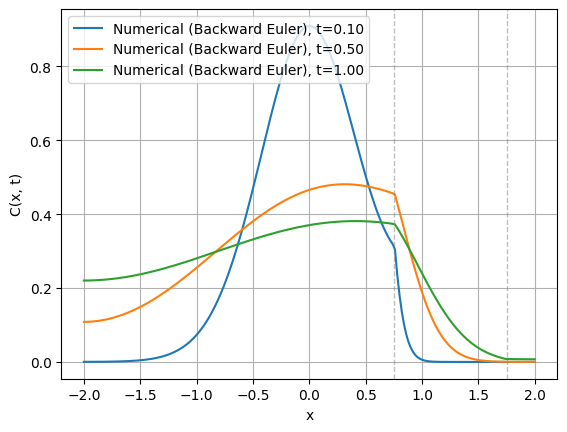

In [ ]:
# ** Backward Euler Implementation ** #
# ** Set parameters ** #
N = 200    # Increased timesteps for stability and accuracy
T = 1.0      # final time 
t = np.linspace(0.0, T, N + 1)      # Time grid (start at 0.0)

M = 200    # Increased spatial points for accuracy
x = np.linspace(-2.0, 2.0, M + 1)    # Space grid

alpha = 0.1 # Diffusion coefficient in the 'defect' region
w = 1
D = make_D(x, alpha, w)
D_max = np.max(D) # Maximum diffusion for stability check

dx = x[1] - x[0] # step sizes
dt = t[1] - t[0]


# Reset solution array
U = np.zeros((N+1, M+1))
U[0] = f(x)

# ** Iterate using Backward Euler ** #
for n in range(0, N):
    # Build coefficient matrix A for the implicit system: A * U^{n+1} = U^n
    # The system size is (M+1) x (M+1)
    
    # Initialize diagonal arrays
    main_diag = np.ones(M+1)
    upper_diag = np.zeros(M)
    lower_diag = np.zeros(M)
    
    # Interior points (i = 1 to M-1)
    for i in range(1, M):
        # Coefficient for U[n+1, i]
        main_diag[i] = 1 + (dt / dx**2) * (D_half[i] + D_half[i-1])
        
        # Coefficient for U[n+1, i+1]
        upper_diag[i] = -(dt / dx**2) * D_half[i]
        
        # Coefficient for U[n+1, i-1]
        lower_diag[i-1] = -(dt / dx**2) * D_half[i-1]
    
    # Left boundary (i=0): Neumann BC
    main_diag[0] = 1 + (2 * dt / dx**2) * D_half[0]
    upper_diag[0] = -(2 * dt / dx**2) * D_half[0]
    
    # Right boundary (i=M): Neumann BC
    main_diag[M] = 1 + (2 * dt / dx**2) * D_half[-1]
    lower_diag[M-1] = -(2 * dt / dx**2) * D_half[-1]
    
    # Create sparse tridiagonal matrix
    A = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], format='csr')
    
    # Right-hand side is U^n
    b = U[n]
    
    # Solve the linear system
    U[n+1] = spsolve(A, b)

# Plot results
time_stamps = [N//10, N//2, N]
for n in time_stamps:
    plt.plot(x, U[n], label=f'Numerical (Backward Euler), t={t[n]:.2f}')

plt.axvline(x=0.75, linestyle='--', color='gray', lw=1, alpha=0.5)
plt.axvline(x=1.75, linestyle='--', color='gray', lw=1, alpha=0.5)
plt.xlabel('x')
plt.ylabel('C(x, t)')
plt.legend()
plt.grid(True)
plt.show()